# Image Processing Fundamentals
- **Purpose**: Load, manipulate, and filter images
- **scipy.ndimage, scipy.misc**: Core image operations
- **Applications**: Enhancement, noise removal, preprocessing

Key concepts:
- **Image as array**: 2D (grayscale) or 3D (color: RGB)
- **Pixel values**: 0-255 (uint8) or 0.0-1.0 (float)
- **Convolution**: Apply kernels (filters) to images
- **Smoothing**: Gaussian blur, median filter
- **Sharpening**: Enhance edges and details

Real applications:
- **Medical**: X-ray/MRI enhancement, tumor detection
- **Satellite**: Land classification, change detection
- **Security**: Face detection, object recognition
- **Manufacturing**: Quality control, defect detection
- **Photography**: Filters, enhancement, restoration

In [1]:
import numpy as np
from scipy import ndimage, misc
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
plt.style.use('seaborn-v0_8-darkgrid')

print("Image processing fundamentals module loaded")

/var/folders/d1/sfvddbbx4tg14yxq7trqmhyw0000gn/T/ipykernel_28740/3982102945.py:2: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import ndimage, misc


Image processing fundamentals module loaded


## Images as Arrays

**Grayscale**: 2D array (height × width)
- Each pixel: single intensity value
- Range: 0 (black) to 255 (white)

**Color (RGB)**: 3D array (height × width × 3)
- Each pixel: [R, G, B] values
- Range: 0-255 per channel

**Coordinate system**: Origin at top-left
- (0, 0) = top-left corner
- (y, x) indexing in numpy

Synthetic Images Created
  Image shape: (200, 300)
  Data type: uint8
  Value range: [0, 253]



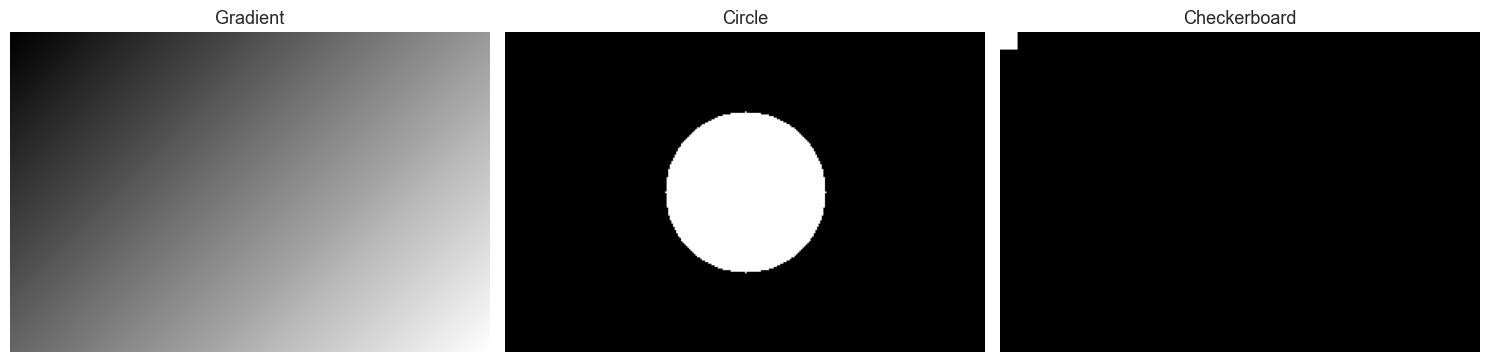

Images are numpy arrays!
Operations: indexing, slicing, arithmetic


In [2]:
# Create synthetic image
height, width = 200, 300
y, x = np.ogrid[:height, :width]

# Gradient image
img_gradient = (x + y) / (height + width) * 255
img_gradient = img_gradient.astype(np.uint8)

# Circle
center_y, center_x = height//2, width//2
radius = 50
img_circle = np.zeros((height, width), dtype=np.uint8)
mask = (y - center_y)**2 + (x - center_x)**2 <= radius**2
img_circle[mask] = 255

# Checkerboard
img_checker = np.zeros((height, width), dtype=np.uint8)
square_size = 20
img_checker[::square_size*2, ::square_size*2] = 255
img_checker[square_size::square_size*2, square_size::square_size*2] = 255
img_checker = ndimage.zoom(img_checker, square_size, order=0)
img_checker = img_checker[:height, :width]

print("Synthetic Images Created")
print(f"  Image shape: {img_gradient.shape}")
print(f"  Data type: {img_gradient.dtype}")
print(f"  Value range: [{img_gradient.min()}, {img_gradient.max()}]\n")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_gradient, cmap='gray')
axes[0].set_title('Gradient', fontsize=13)
axes[0].axis('off')

axes[1].imshow(img_circle, cmap='gray')
axes[1].set_title('Circle', fontsize=13)
axes[1].axis('off')

axes[2].imshow(img_checker, cmap='gray')
axes[2].set_title('Checkerboard', fontsize=13)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Images are numpy arrays!")
print("Operations: indexing, slicing, arithmetic")

## Gaussian Smoothing

**Purpose**: Reduce noise, blur image

**Gaussian kernel**: 2D Gaussian function
\[ G(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}} \]

**Parameter σ (sigma)**:
- Small: Subtle blur
- Large: Strong blur

**Function**: `ndimage.gaussian_filter(image, sigma)`

**Use when**: Noise removal, preprocessing

Gaussian Smoothing for Noise Reduction
  Noise level: σ=30



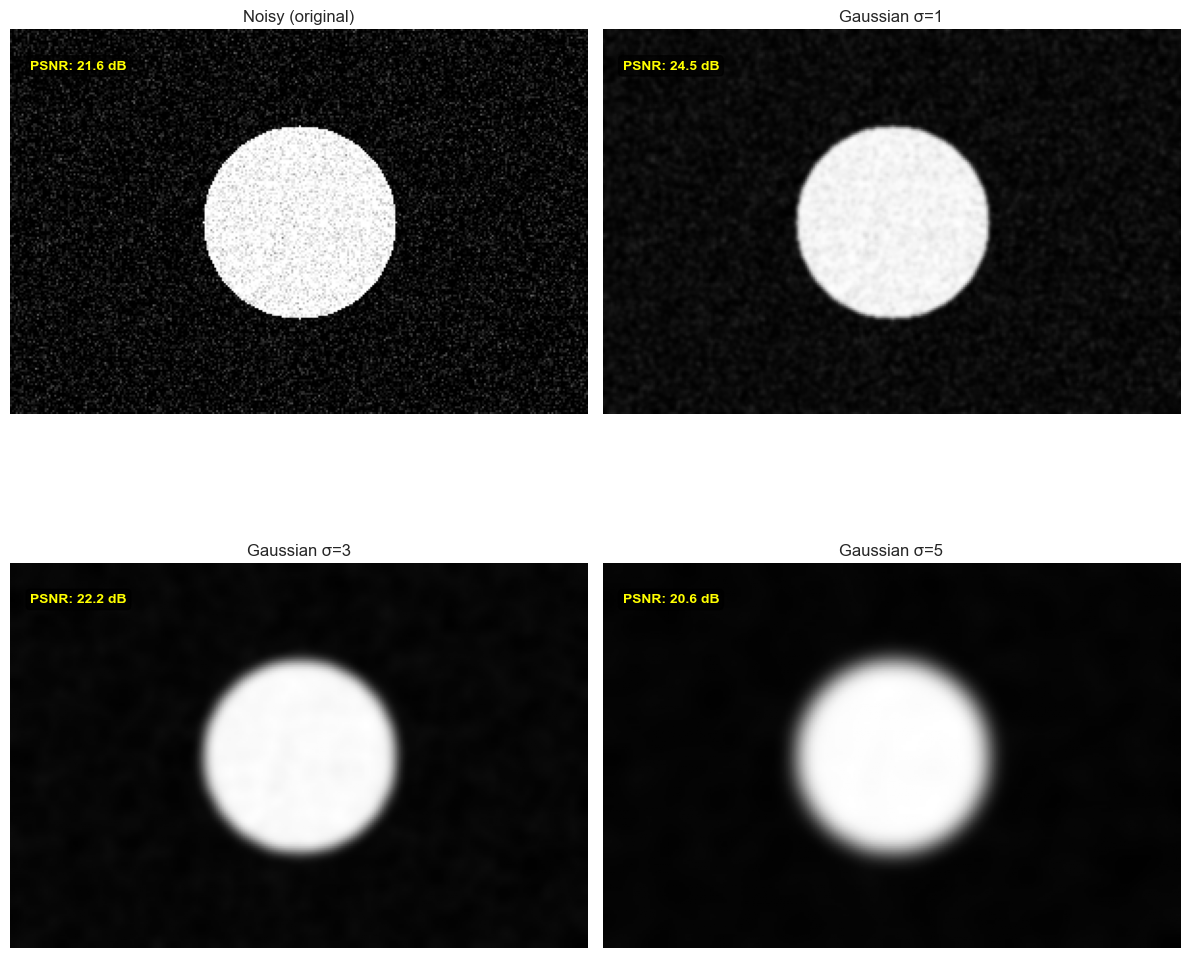

Observations:
  σ=1: Light blur, some noise remains
  σ=3: Good balance (best PSNR)
  σ=5: Heavy blur, edges softened

Trade-off: Noise reduction ↔ Edge preservation


In [3]:
# Add noise to circle image
np.random.seed(42)
noise = np.random.randn(height, width) * 30
img_noisy = np.clip(img_circle + noise, 0, 255).astype(np.uint8)

print("Gaussian Smoothing for Noise Reduction")
print(f"  Noise level: σ=30\n")

# Apply Gaussian blur with different sigma
sigma_values = [0, 1, 3, 5]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, sigma in enumerate(sigma_values):
    if sigma == 0:
        img_filtered = img_noisy
        title = 'Noisy (original)'
    else:
        img_filtered = ndimage.gaussian_filter(img_noisy, sigma=sigma)
        title = f'Gaussian σ={sigma}'
    
    axes[i].imshow(img_filtered, cmap='gray')
    axes[i].set_title(title, fontsize=12)
    axes[i].axis('off')
    
    # Calculate noise reduction (compared to original clean)
    mse = np.mean((img_filtered.astype(float) - img_circle.astype(float))**2)
    psnr = 10 * np.log10(255**2 / mse) if mse > 0 else np.inf
    axes[i].text(10, 20, f'PSNR: {psnr:.1f} dB', 
                color='yellow', fontsize=10, weight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

print("Observations:")
print("  σ=1: Light blur, some noise remains")
print("  σ=3: Good balance (best PSNR)")
print("  σ=5: Heavy blur, edges softened")
print("\nTrade-off: Noise reduction ↔ Edge preservation")

## Median Filter

**Purpose**: Remove salt-and-pepper noise

**How it works**: Replace each pixel with median of neighborhood

**Advantages**:
- Excellent for impulse noise
- Preserves edges better than Gaussian
- Non-linear filter

**Function**: `ndimage.median_filter(image, size)`

**Parameter**: size of neighborhood (e.g., 3, 5, 7)

Median Filter vs Gaussian for Salt-and-Pepper Noise
  Noise ratio: 5.0%



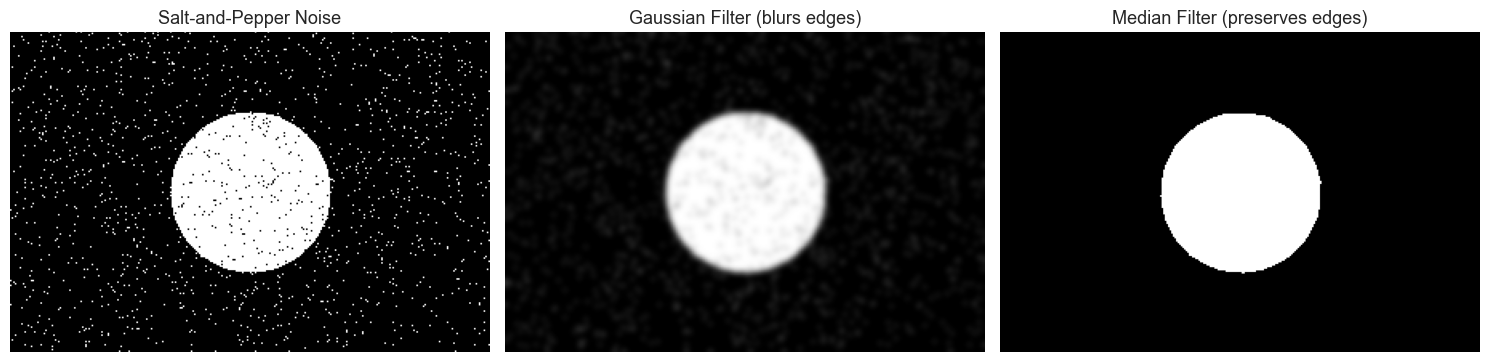

Median filter superior for impulse noise!
Edges remain sharp.


In [4]:
# Add salt-and-pepper noise
img_sp = img_circle.copy()
noise_ratio = 0.05
n_noise = int(noise_ratio * img_sp.size)

# Salt (white)
coords_salt = [np.random.randint(0, i, n_noise//2) for i in img_sp.shape]
img_sp[coords_salt[0], coords_salt[1]] = 255

# Pepper (black)
coords_pepper = [np.random.randint(0, i, n_noise//2) for i in img_sp.shape]
img_sp[coords_pepper[0], coords_pepper[1]] = 0

print("Median Filter vs Gaussian for Salt-and-Pepper Noise")
print(f"  Noise ratio: {noise_ratio*100}%\n")

# Apply filters
img_gaussian = ndimage.gaussian_filter(img_sp, sigma=2)
img_median = ndimage.median_filter(img_sp, size=5)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_sp, cmap='gray')
axes[0].set_title('Salt-and-Pepper Noise', fontsize=13)
axes[0].axis('off')

axes[1].imshow(img_gaussian, cmap='gray')
axes[1].set_title('Gaussian Filter (blurs edges)', fontsize=13)
axes[1].axis('off')

axes[2].imshow(img_median, cmap='gray')
axes[2].set_title('Median Filter (preserves edges)', fontsize=13)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Median filter superior for impulse noise!")
print("Edges remain sharp.")

## Image Sharpening

**Purpose**: Enhance edges and details

**Method**: Unsharp masking
1. Blur original image
2. Subtract blur from original → edges
3. Add edges back to original (amplified)

**Formula**: `sharpened = original + α × (original - blurred)`

**Parameter α**: Sharpening strength

**Use when**: Image too soft, need detail enhancement

Image Sharpening via Unsharp Masking



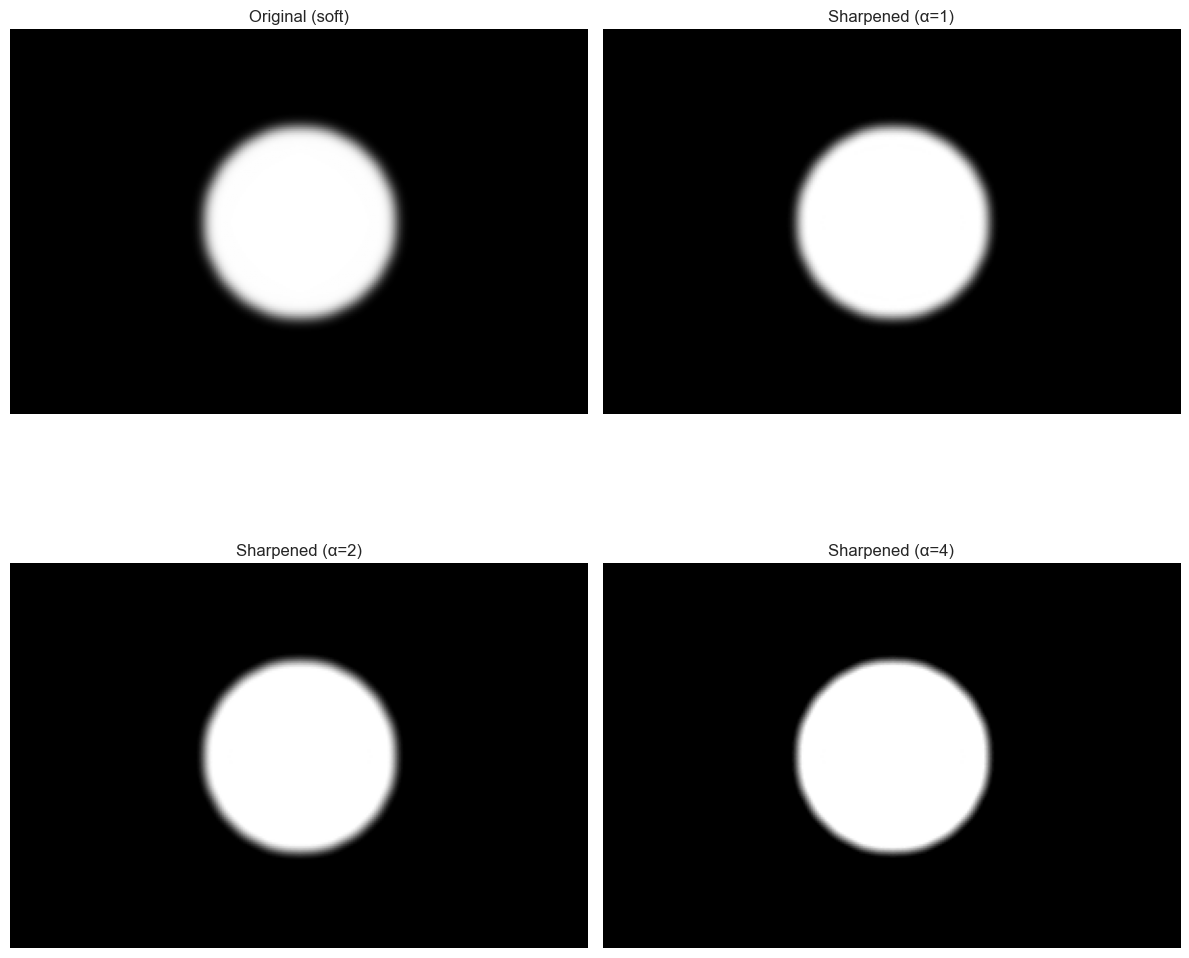

Sharpening results:
  α=1: Subtle sharpening
  α=2: Moderate sharpening
  α=4: Strong sharpening (may introduce artifacts)

Photoshop 'Sharpen' uses this technique!


In [5]:
# Slightly blurred image
img_soft = ndimage.gaussian_filter(img_circle, sigma=3)

print("Image Sharpening via Unsharp Masking\n")

# Unsharp mask
alpha_values = [0, 1, 2, 4]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, alpha in enumerate(alpha_values):
    # Blur
    blurred = ndimage.gaussian_filter(img_soft, sigma=2)
    
    # Edges
    edges = img_soft.astype(float) - blurred.astype(float)
    
    # Sharpen
    sharpened = img_soft.astype(float) + alpha * edges
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    if alpha == 0:
        title = 'Original (soft)'
    else:
        title = f'Sharpened (α={alpha})'
    
    axes[i].imshow(sharpened, cmap='gray')
    axes[i].set_title(title, fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("Sharpening results:")
print("  α=1: Subtle sharpening")
print("  α=2: Moderate sharpening")
print("  α=4: Strong sharpening (may introduce artifacts)")
print("\nPhotoshop 'Sharpen' uses this technique!")

## Real Example: Medical Image Enhancement

**Problem**: X-ray images often noisy and low contrast

**Pipeline**:
1. Noise reduction (Gaussian)
2. Contrast enhancement (histogram equalization)
3. Sharpening (unsharp mask)

**Application**: Improve diagnostic quality

Medical Image Enhancement Pipeline

Processing steps:
  1. Gaussian denoising (σ=1.5)
  2. Histogram equalization (contrast)
  3. Unsharp masking (sharpening)



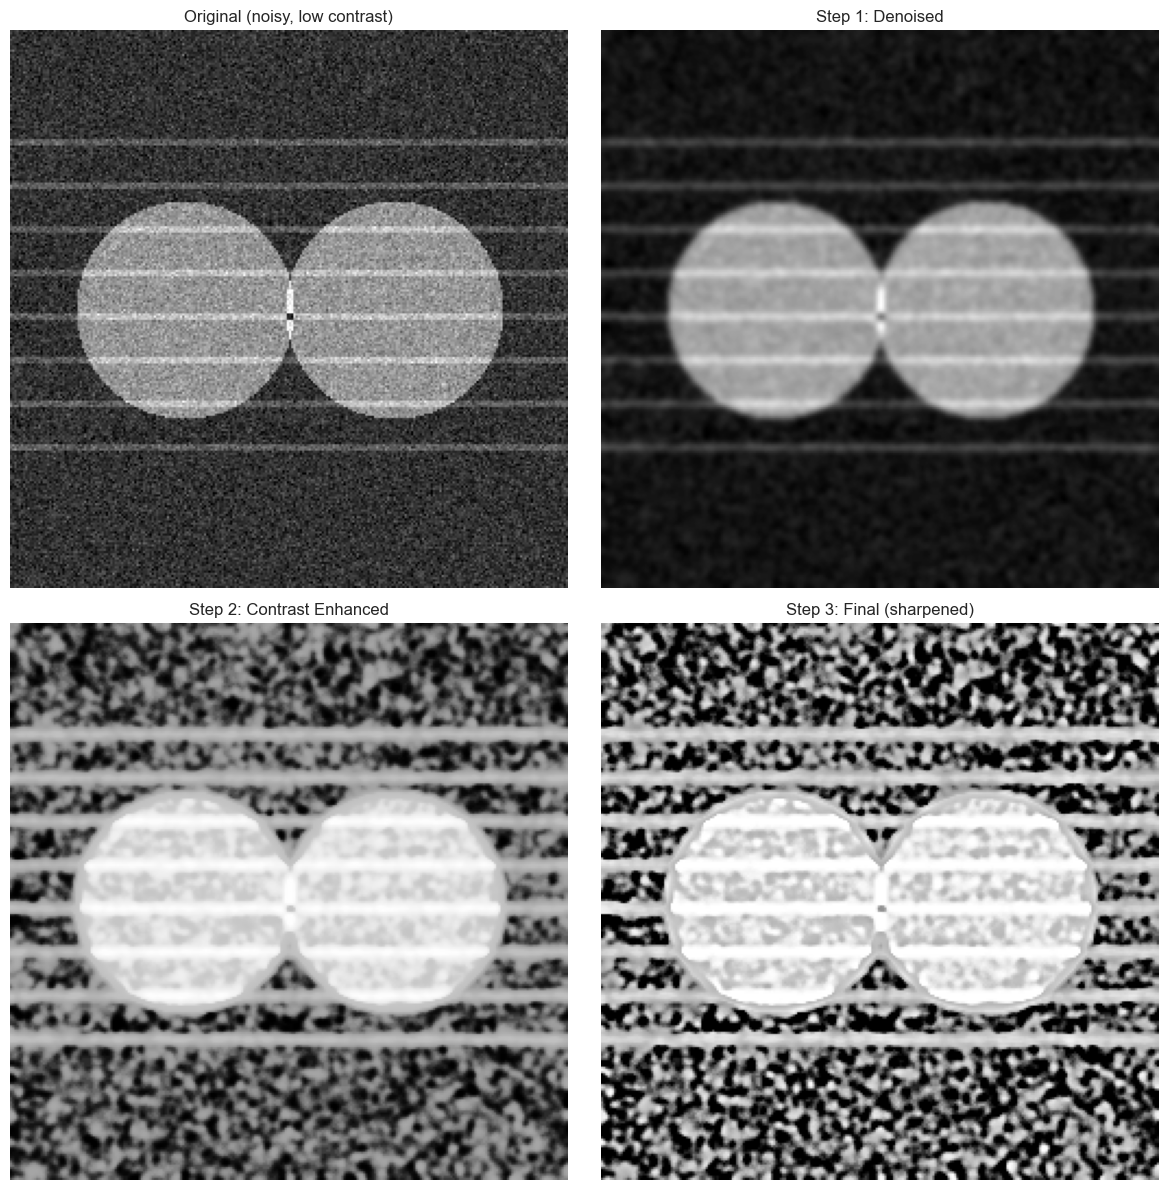

Enhancement improves:
  - Noise reduction
  - Contrast (structures visible)
  - Edge clarity

Critical for medical diagnosis!


In [6]:
# Simulate medical image (chest X-ray-like)
np.random.seed(42)
medical_img = np.zeros((256, 256), dtype=np.uint8)

# Add structures (lungs, ribs)
y, x = np.ogrid[:256, :256]
# Lungs (two circles)
lung_left = ((y-128)**2 + (x-80)**2 < 50**2).astype(float) * 100
lung_right = ((y-128)**2 + (x-176)**2 < 50**2).astype(float) * 100
# Ribs (horizontal lines)
ribs = np.zeros_like(medical_img, dtype=float)
for i in range(50, 200, 20):
    ribs[i:i+3, :] = 150

medical_img = (50 + lung_left + lung_right + ribs*0.3).astype(np.uint8)

# Add noise
noise = np.random.randn(256, 256) * 20
medical_noisy = np.clip(medical_img + noise, 0, 255).astype(np.uint8)

print("Medical Image Enhancement Pipeline\n")

# Step 1: Denoise
medical_denoised = ndimage.gaussian_filter(medical_noisy, sigma=1.5)

# Step 2: Contrast enhancement (histogram equalization)
def hist_equalization(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img.shape).astype(np.uint8)

medical_enhanced = hist_equalization(medical_denoised)

# Step 3: Sharpen
blurred = ndimage.gaussian_filter(medical_enhanced, sigma=2)
edges = medical_enhanced.astype(float) - blurred.astype(float)
medical_sharp = np.clip(medical_enhanced + 1.5 * edges, 0, 255).astype(np.uint8)

print("Processing steps:")
print("  1. Gaussian denoising (σ=1.5)")
print("  2. Histogram equalization (contrast)")
print("  3. Unsharp masking (sharpening)\n")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(medical_noisy, cmap='gray')
axes[0, 0].set_title('Original (noisy, low contrast)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(medical_denoised, cmap='gray')
axes[0, 1].set_title('Step 1: Denoised', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(medical_enhanced, cmap='gray')
axes[1, 0].set_title('Step 2: Contrast Enhanced', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(medical_sharp, cmap='gray')
axes[1, 1].set_title('Step 3: Final (sharpened)', fontsize=12)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Enhancement improves:")
print("  - Noise reduction")
print("  - Contrast (structures visible)")
print("  - Edge clarity")
print("\nCritical for medical diagnosis!")

## Summary

### Core Operations:

| Operation | Function | Use Case |
|-----------|----------|----------|
| **Gaussian blur** | `ndimage.gaussian_filter()` | Noise reduction, smoothing |
| **Median filter** | `ndimage.median_filter()` | Salt-and-pepper noise |
| **Sharpening** | Unsharp masking | Enhance edges, details |
| **Rotation** | `ndimage.rotate()` | Geometric transform |
| **Zoom** | `ndimage.zoom()` | Resize, interpolation |

### Key Functions:

```python
from scipy import ndimage

# Smoothing
blurred = ndimage.gaussian_filter(img, sigma=2)
median = ndimage.median_filter(img, size=5)

# Sharpening (unsharp mask)
blurred = ndimage.gaussian_filter(img, sigma=2)
edges = img.astype(float) - blurred
sharpened = img + alpha * edges

# Geometric transforms
rotated = ndimage.rotate(img, angle=45, reshape=False)
zoomed = ndimage.zoom(img, zoom=2.0, order=3)
```

### Filter Selection:

**Gaussian blur**:
- Gaussian noise
- General smoothing
- Preprocessing

**Median filter**:
- Salt-and-pepper noise
- Preserves edges
- Outlier removal

**Unsharp masking**:
- Too soft images
- Detail enhancement
- Photography

### Applications:

✓ **Medical imaging**: X-ray, MRI, CT enhancement  
✓ **Photography**: Filters, corrections, effects  
✓ **Satellite**: Land use, change detection  
✓ **Security**: Surveillance, face recognition  
✓ **Manufacturing**: Quality control, inspection  

### Best Practices:

✓ **Choose right filter**: Gaussian vs median  
✓ **Tune parameters**: Test on real data  
✓ **Consider edges**: Median preserves better  
✓ **Pipeline**: Denoise → enhance → sharpen  
✓ **Check range**: Clip to [0, 255] or [0, 1]  

### Next Topics:

- **Edge detection**: Sobel, Canny, Prewitt
- **Morphology**: Erosion, dilation, opening, closing
- **Features**: Corners, blobs, SIFT, HOG
- **Segmentation**: Thresholding, watershed, clustering
- **Advanced**: Transforms, restoration, registration